# Distance Estimation and Angle Recovery

TODO: put equateions

## Content

1. [Data Preparation](Read-Data)
2. 

## Read Data

Data used:
- Protein: 5j0n (symmetric protein)
- Projections: 5K
- Coverage: Half-sphere

![](figures/5j0n.pdb1-500.jpg)

In [32]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [1]:
import os
import h5py
import numpy as np
import time

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count
from IPython.display import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from cryoem.conversions import d_q, euler2quaternion
from cryoem.distance_estimation import train_siamese
import ipyvolume as ipv

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12711610727955212974
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13665838740804961051
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 18289124327571746158
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11322146816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17085496971145777942
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:3b:00.0, compute capability: 3.5"
]


In [3]:
PROTEIN="5j0n"#"5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [4]:
# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


### True Angles

In [5]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

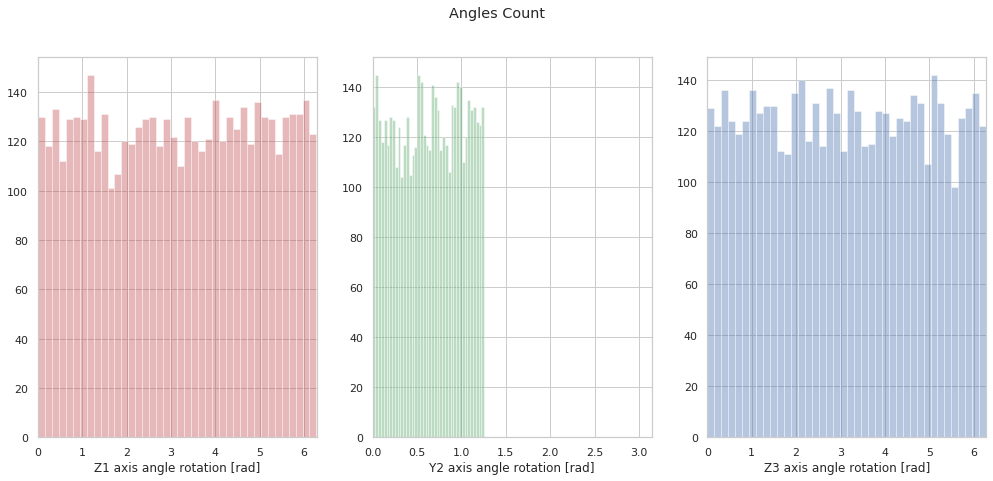

In [6]:
plot_angles_count(angles_true)

---

## Prepare for training

In [7]:
from sklearn.model_selection import train_test_split
from cryoem.distance_estimation import create_pairs

In [8]:
X, y = np.array(data['Projections'], dtype=np.float32), np.array(data['Angles'], dtype=np.float32)

In [9]:
X_max_px = np.max(X)
X = X/X_max_px
print(f"Projection images will be normalized to have pixels ranging from 0 to 1 instead of 1 to {X_max_px}")

Projection images will be normalized to have pixels ranging from 0 to 1 instead of 1 to 15.457941055297852


In [10]:
# the data, split between train and test sets
train_idx, test_idx = train_test_split(range(NUM_PROJECTIONS), 
                                       test_size=0.33, 
                                       random_state=42)
train_idx, val_idx= train_test_split(train_idx, 
                                     test_size=0.25, 
                                     random_state=1)

train_idx = sorted(train_idx)
val_idx = sorted(val_idx)
test_idx = sorted(test_idx)

In [11]:
# TODO: 2 problems, bigger image now it is 275 instead of 116
# and the tr_pairs bellow the number is a lot decreased

In [12]:
# TODO: increase these values, it is just important to have the batches small enough
tr_pairs, tr_y = create_pairs(X, y, indices=train_idx, num_pairs=60000)
tr_pairs = tr_pairs.reshape(list(tr_pairs.shape) + [-1])
tr_y = tf.cast(tr_y, dtype=  tf.float32)

val_pairs, val_y = create_pairs(X, y, indices=val_idx, num_pairs=20000)
val_pairs = val_pairs.reshape(list(val_pairs.shape) + [-1])
val_y = tf.cast(val_y, dtype=tf.float32)

te_pairs, te_y = create_pairs(X, y, indices=test_idx, num_pairs=20000)
te_pairs = te_pairs.reshape(list(te_pairs.shape) + [-1])
te_y = tf.cast(te_y, dtype=tf.float32)

# 1. Distance Estimation

## dP/dQ plot

In [13]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density

In [15]:


def d_p(p1, p2):
    # (learned) distance between two images.
    # for now, Euclid dist
    p1 = tf.convert_to_tensor(value=p1, dtype=np.float64)
    p2 = tf.convert_to_tensor(value=p2, dtype=np.float64)
    p1 = tf.reshape(p1, (len(p1), -1))
    p2 = tf.reshape(p2, (len(p2), -1))

    if len(p1.shape) > 1:
        dist = tf.norm(p1-p2, ord='euclidean', axis=1, keepdims=True)
    else:
        dist = tf.norm(p1-p2, ord='euclidean')

    return dist

# def d_p(p1, p2):
#     # (learned) distance between two images.
#     # for now, Euclid dist
#     p1 = tf.convert_to_tensor(value=p1, dtype=np.float64)
#     p2 = tf.convert_to_tensor(value=p2, dtype=np.float64)
#     p1 = tf.reshape(p1, (len(p1), -1))
#     p2 = tf.reshape(p2, (len(p2), -1))

#     if len(p1.shape) > 1:
#         dist = tf.norm(p1-p2, ord='euclidean', axis=1, keepdims=True)
#     else:
#         dist = tf.norm(p1-p2, ord='euclidean')

#     dist = dist/ max_dist
#     dist = (dist * (max_dQ_val - min_dQ_val)) + min_dQ_val
#     return dist

# def get_boundry():
#     idx1 = list(np.zeros(5000, dtype=int))
#     idx2 = list(np.arange(0, 5000, dtype=int))

#     q1_true = euler2quaternion([angles_true[i] for i in idx1])
#     q2_true = euler2quaternion([angles_true[i] for i in idx2])

#     p1 = [X[i] for i in idx1]
#     p2 = [X[i] for i in idx2]

#     dP_values = _d_p(p1, p2).numpy().T[0]
#     dQ_values = d_q(q1_true, q2_true).numpy()
    
#     max_dist = max(dP_values)
#     min_dQ_val = min(dQ_values)
#     max_dQ_val = max(dQ_values)
#     return max_dist, min_dQ_val, max_dQ_val

# max_dist, min_dQ_val, max_dQ_val = get_boundry()


In [16]:
idx1 = list(np.random.choice(test_idx, size=800))
idx2 = list(np.random.choice(test_idx, size=800))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).numpy().T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

In [17]:
max(dP_values), min(dP_values)

(9.891206780077551, 0.0)

In [18]:
max(dQ_values), min(dQ_values)

(3.1414040666089713, 8.429369702178807e-08)

In [22]:
np.savez("data/5j0n/5j0n_L2_dPdQ_plot", dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

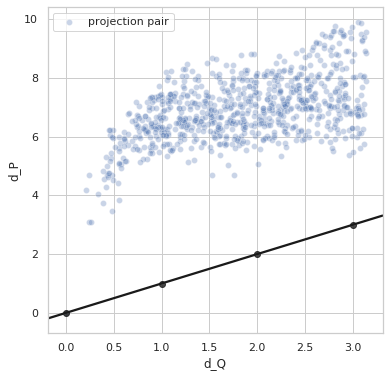

In [19]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

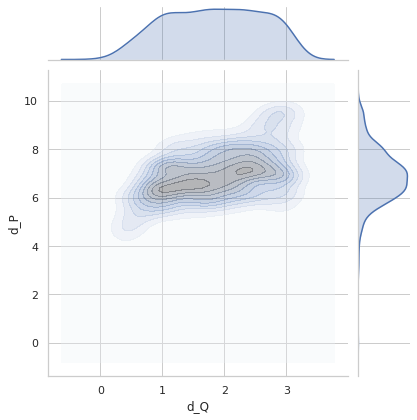

In [20]:
plot_dP_dQ_density(dP_values, dQ_values)

In [21]:
coeffs4dP = np.polyfit(dQ_values, dP_values, deg=14)
convert2dP = np.poly1d(coeffs4dP)

def loss(dQ_values, dP_values):
    # The mean doesn't depend on the batch size.
    distance = tf.math.polyval(coeffs4dP, dQ_values)
    return tf.reduce_mean(tf.pow((distance - dP_values), 2))

In [22]:
loss(dQ_values, dP_values).numpy()

0.7237750060048365

In [24]:
# np.sqrt(1/(len(dQ_values)-1)*np.sum(np.power(dP_values-dQ_values, 2)))

# 2. Angle Recovery

## Angle Recovery

Perfect distances. Learning rate 0.01

In [25]:
from cryoem.angle_recovery import train_angle_recovery

In [26]:
X = tf.cast(X, dtype=tf.float64)

In [27]:
# QUATERNION VARIABLE
import time
import numpy as np
from IPython import display as IPyDisplay
from tensorflow.keras.optimizers import Adam
import seaborn as sns; sns.set(style="white", color_codes=True)
from tensorflow_graphics.geometry.transformation import quaternion
from cryoem.conversions import euler2quaternion, d_q, quaternion2euler
import tensorflow as tf
import matplotlib.pyplot as plt

def train_angle_recovery(steps, batch_size, projection_idx, 
                        in_data, distance_fn, angles_predicted=None,
                        learning_rate=0.01, 
                        optimization=False): 
    time_start = time.time()
    
    optimizer = Adam(learning_rate=learning_rate)
    
    low_ang = [0.0*np.pi, 0.0*np.pi, 0.0*np.pi]
    high_ang = [2.0*np.pi, 0.4*np.pi, 2.0*np.pi]            
    euler = np.random.uniform(low=[low_ang[0], low_ang[1], low_ang[2]], 
                          high=[high_ang[0], high_ang[1], high_ang[2]],
                          size=(len(in_data), 3))
    q_predicted = [tf.Variable(q) for q in euler2quaternion(euler)]
#     q_predicted = [tf.Variable(tf.cast(quaternion.normalized_random_uniform((1,)), dtype=tf.float64)) for _ in range(len(in_data))]
    
    if in_data.shape[1] == 3:
        in_data = euler2quaternion(in_data)
    
    losses = np.empty(steps)
    report = ""
    found_minimizer = False
    
    print(time.time()-time_start)
    
    for step, idx1, idx2 in sample_iter(steps, projection_idx, batch_size, style="random"):
        #q_predicted = quaternion.normalize(q_predicted)
        q1 = [q_predicted[i] for i in idx1]
        q2 = [q_predicted[i] for i in idx2]

        # Compute distances
        in1 = [in_data[i] for i in idx1]
        in2 = [in_data[i] for i in idx2]
        
        distance_target = distance_fn(in1, in2)

        # Optimize by gradient descent.
        if optimization:
            losses[step-1], gradients = gradient(q1, q2, distance_target)
            optimizer.apply_gradients(zip(gradients, q1 + q2))
            
            # Visualize progress periodically
            if step % 10 == 0:
                plt.close();
                sns.set(style="white", color_codes=True)
                sns.set(style="whitegrid")

                fig, axs = plt.subplots(figsize=(10,7))

                # Optimization loss subplot
                axs.plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
                axs.set_xlabel('time [s]')
                axs.set_ylabel('loss');
                axs.set_title(f"[{step}/{steps}] Angle alignment optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")

                # T - Distance count subplot (full)
                #d2 = d_q(in_data, q_predicted)
                #axs[1].set_xlim(0, np.pi)
                #axs[1].set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
                #s = sns.distplot(d2, kde=False, bins=100, ax=axs[1], axlabel="Distance [rad]", color="r")
                #max_count = int(max([h.get_height() for h in s.patches]))
                #axs[1].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
                
                # NT - Distance count subplot (full)
                #q_predicted_T = euler2quaternion(quaternion2euler(q_predicted, transposed=True))
                #d2 = d_q(in_data, q_predicted_T)
                #axs[2].set_xlim(0, np.pi)
                #axs[2].set_title(f"FULL: [{step}/{steps}] TRANSPOSED Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
                #s = sns.distplot(d2, kde=False, bins=100, ax=axs[2], axlabel="Distance [rad]", color="r")
                #max_count = int(max([h.get_height() for h in s.patches]))
                #axs[2].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

                IPyDisplay.clear_output(wait=True)
                IPyDisplay.display(plt.gcf())
                plt.close();
                time.sleep(1.0)
                
                if found_minimizer:
                    break;
        else:
            losses[step-1] = loss(a1, a2, distance_target)
        
        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time.time() - time_start
            report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}\n'
            
        if step >= 1001 and np.mean(losses[step-1001:step-1]) < 1e-8:
            found_minimizer = True
            
        if step >= 2001 and np.abs(np.mean(losses[step-1000:step-1])-np.mean(losses[step-2000:step-1000])) < 1e-7:
            found_minimizer = True
            
    print(report)
    return quaternion.normalize(q_predicted), losses
        
def sample_iter(steps, projection_idx, num_pairs, style="random", k=None):

    for step in range(1, steps+1):
        if not k and style != "random":
            raise ValueError("Please specify k for kNN for sample_pairs method")
        
        if style=="random":
            idx1 = list(np.random.choice(projection_idx, size=num_pairs))
            idx2 = list(np.random.choice(projection_idx, size=num_pairs))
        
        elif style=="knn":
            idx1 = list(np.random.choice(projection_idx, size=num_pairs))
            indices_p, distances_p, A_p = get_knn_projections(k=k)
            idx2 = [indices_p[i][np.random.randint(1, k)] for i in idx1]
    
        elif style=="knn_and_random":
            # select random sample for the first element of pair
            idx1 = list(np.random.choice(projection_idx, size=num_pairs))
            
            # half from kNN
            indices_p, distances_p, A_p = get_knn_projections(k=k)
            idx2_knn = [indices_p[i][np.random.randint(1, k)] for i in idx1[:num_pairs//2]]
            idx2_random = list(np.random.randint(0, num_projections, num_pairs//2))
            # half random
            idx2 = idx2_knn + idx2_random
        
        yield step, idx1, idx2
        
def loss(q1_predicted, q2_predicted, distance_target):
    # The mean doesn't depend on the batch size.
    dQ_values = d_q(q1_predicted, q2_predicted) 
    distance = tf.math.polyval(coeffs4dP, dQ_values)
    return tf.reduce_mean(tf.pow((distance - distance_target), 2))

def gradient(q1_predicted, q2_predicted, distance_target):
    with tf.GradientTape() as tape:
        loss_value = loss(q1_predicted, q2_predicted, distance_target)
        gradient = tape.gradient(loss_value, q1_predicted + q2_predicted)
        
    return loss_value, gradient

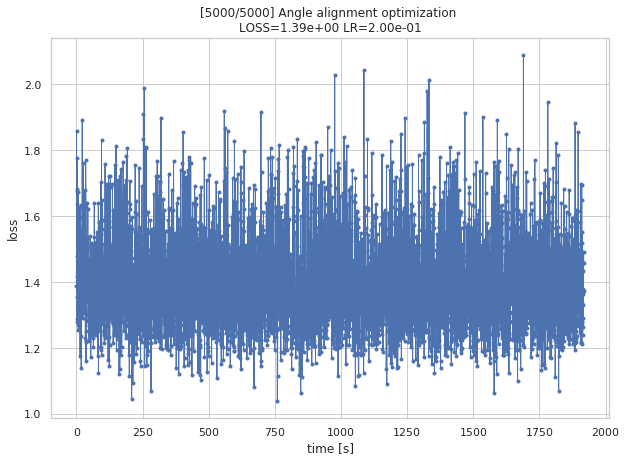

step 500/5000 (204s): loss = 1.29e+00
step 1000/5000 (392s): loss = 1.56e+00
step 1500/5000 (580s): loss = 1.26e+00
step 2000/5000 (770s): loss = 1.42e+00
step 2500/5000 (959s): loss = 1.64e+00
step 3000/5000 (1149s): loss = 1.37e+00
step 3500/5000 (1341s): loss = 1.28e+00
step 4000/5000 (1532s): loss = 1.36e+00
step 4500/5000 (1725s): loss = 1.37e+00
step 5000/5000 (1919s): loss = 1.49e+00



In [28]:
# train_angle_recovery(steps=300000, 
#                      batch_size=256, 
#                      projection_idx=test_idx, 
#                      angles_predicted=angles_predicted, 
#                      est_dist_input=X, 
#                      est_dist=d_p, 
#                      learning_rate=0.01, 
#                      optimization=True)
q_predicted, losses = train_angle_recovery(steps=5000, 
                                  batch_size=512, 
                                 projection_idx=test_idx, 
                                 in_data=X, 
                                 distance_fn=d_p, 
                                 learning_rate=0.2, #0.1, 
                                 optimization=True)

In [31]:
np.save("data/5j0n/predicted_quaternions_L2_losses_ar2.npy", losses)

In [29]:
q_save = np.zeros((len(q_predicted),4))
for i, q in enumerate(q_predicted):
    q_save[i] = q.numpy()
                    
np.save("data/5j0n/predicted_quaternions_L2.npy", q_save)

## Angle Alignment

In [42]:
qp = np.load("data/5j0n/predicted_quaternions_L2.npy")

transposed = True
ap = quaternion2euler(qp, transposed=transposed)

np.save("data/5j0n/predicted_angles_L2.npy", ap)

In [43]:
# from cryoem.plots import plot_images

# plot_images(ap, data["Projections"], indices=range(100), img_size_scale=0.05)

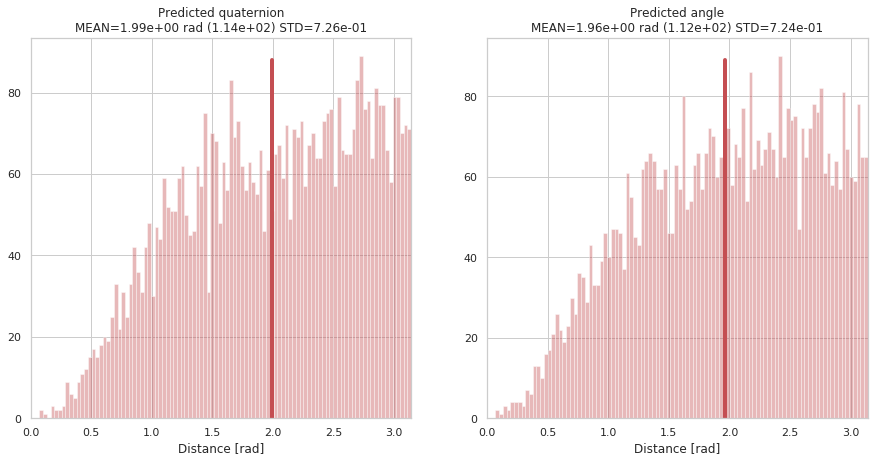

In [44]:
# check: both plots should be the same (if transposed=False)
fig, axs = plt.subplots(1, 2, figsize=(15,7))
d2 = d_q(euler2quaternion(angles_true), qp)
axs[0].set_xlim(0, np.pi)
axs[0].set_title(f"Predicted quaternion\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
s = sns.distplot(d2, kde=False, bins=100, ax=axs[0], axlabel="Distance [rad]", color="r")
max_count = int(max([h.get_height() for h in s.patches]))
axs[0].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

d3 = d_q(euler2quaternion(angles_true), euler2quaternion(ap))
axs[1].set_xlim(0, np.pi)
axs[1].set_title(f"Predicted angle\nMEAN={np.mean(d3):.2e} rad ({np.degrees(np.mean(d3)):.2e}) STD={np.std(d3):.2e}")
s = sns.distplot(d3, kde=False, bins=100, ax=axs[1], axlabel="Distance [rad]", color="r")
max_count = int(max([h.get_height() for h in s.patches]))
axs[1].plot([np.mean(d3)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

In [45]:
from cryoem.angle_alignment import training_angle_alignment, update_quaternion

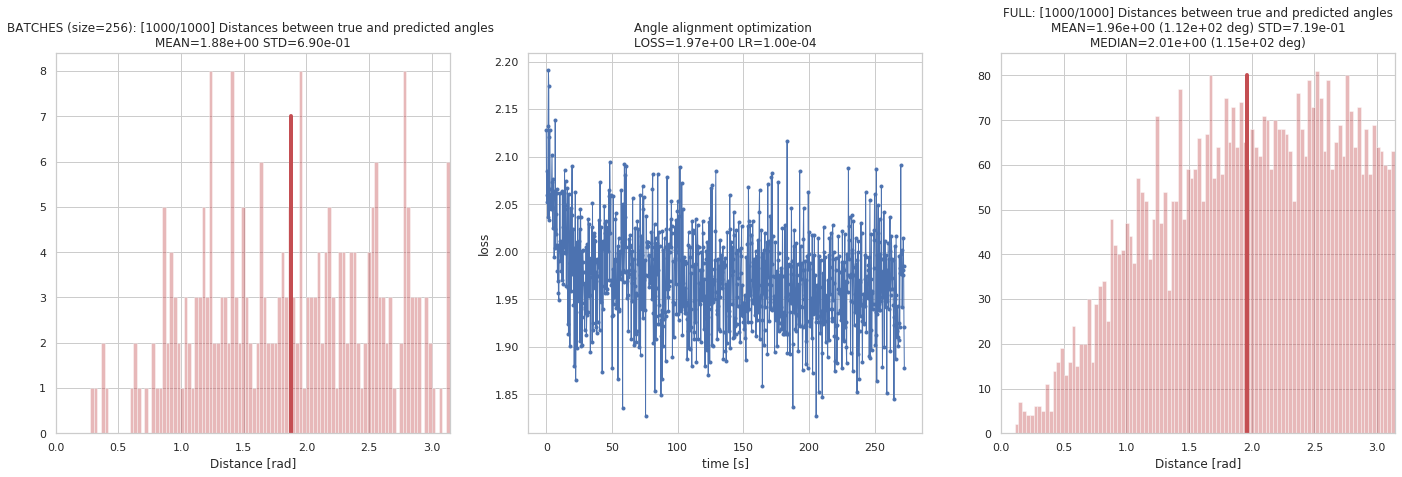

step 100/1000 (28s): loss = 2.02e+00
step 200/1000 (56s): loss = 1.98e+00
step 300/1000 (83s): loss = 1.98e+00
step 400/1000 (110s): loss = 1.97e+00
step 500/1000 (138s): loss = 1.96e+00
step 600/1000 (165s): loss = 1.97e+00
step 700/1000 (192s): loss = 1.96e+00
step 800/1000 (220s): loss = 1.95e+00
step 900/1000 (247s): loss = 1.96e+00
step 1000/1000 (274s): loss = 1.96e+00



In [47]:
m, rotation, loss = training_angle_alignment(m=[1.0, 1.0, 1.0, 1.0],
                                             steps=1000, 
                                             batch_size=256, 
                                             projection_idx=range(NUM_PROJECTIONS), 
                                             learning_rate=0.01, 
                                             angles_true=angles_true, 
                                             angles_predicted=ap)

In [48]:
m, rotation[0].numpy(), loss[-1]

([1.0, 1.0, 1.0, 1.0],
 array([1.64800999, 6.27582458, 3.09732409, 6.29747329, 3.17295101,
        2.3197146 ]),
 1.8772620062240986)

In [49]:
qpa = update_quaternion(m=m, 
                        a_R=rotation, 
                        q_predicted=qp)

transposed = False
angles_predicted = quaternion2euler(qpa, transposed=transposed).numpy()

np.save("data/5j0n/predicted_angles_L2_updated.npy", angles_predicted)

In [108]:
# Image(filename='../3-reconstruction/data/5a1a_projections_and_angles_predicted_updated.png')

---